In [1]:
import os
import h5py as h5
import json

import numpy as np  # arrays
import matplotlib.pyplot as plt

from utils import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_sac/"
data_path = base_path + "test_run/"
exp_name = "test"
load_exp = False

if load_exp:
    with h5.File(os.path.join(data_path, exp_name + ".h5"), "r") as f:
        data = unpack_hdf(f)
else:
    import sac_pair
    model = sac_pair.SacPair()
    runner = sac_pair.Runner(model, data_path=data_path)
#     data = runner.velocity_run(
    data = runner.velocity_mechanism_run(
        velocities=[.1, .25, .5, .75, 1, 1.25, 1.5, 1.75, 2],
    )
    pack_hdf(data_path + exp_name, data)

model_params = json.loads(data["control"]["model_params"])
exp_params = json.loads(data["control"]["exp_params"])
exps = {k: v["data"] for k, v in data.items()}

trial 0... 0.10 0.25 0.50 0.75 1.00 1.25 1.50 1.75 2.00 
trial 0... 0.10 0.25 0.50 0.75 1.00 1.25 1.50 1.75 2.00 
trial 0... 0.10 0.25 0.50 0.75 1.00 1.25 1.50 1.75 2.00 
trial 0... 0.10 0.25 0.50 0.75 1.00 1.25 1.50 1.75 2.00 


In [4]:
rec_xaxis = np.arange(0, exp_params["tstop"] + exp_params["dt"], exp_params["dt"])
velocities = exp_params["velocities"]

### Experiment dict contents / shapes

In [5]:
print("Electrode recording dict keys:", [k for k in exps["control"]["soma"]["a"].keys()])
print("Synapse recording dict keys:", [k for k in exps["control"]["gaba"]["a"].keys()])
print("Recording shape:", exps["control"]["soma"]["a"]["v"].shape)

Electrode recording dict keys: ['v']
Synapse recording dict keys: ['i', 'g']
Recording shape: (1, 9, 4001)


### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak_dsi:** Using the deflection from the minimum voltage
- **thresh_area_dsi:** Area under the voltage above a specified threshold
- **gaba_dsi:** Area of GABA conductance *applied* the *opposing* SAC  

In [6]:
thresh = -55
dsis = {
    cond: {
        "peak": pn_dsi(
            peak_vm_deflection(exp["term"]["a"]["v"]),
            peak_vm_deflection(exp["term"]["b"]["v"])
        ),
        "thresh_area": pn_dsi(
            thresholded_area(exp["term"]["a"]["v"], thresh),
            thresholded_area(exp["term"]["b"]["v"], thresh)
        ),
        "gaba": pn_dsi(
            np.sum(exp["gaba"]["b"]["g"], axis=-1), 
            np.sum(exp["gaba"]["a"]["g"], axis=-1)
        )
    }
    for cond, exp in exps.items()
}

### Velocity Tuning of PN DSi
How each of the above measures change over increasing voltage.

<IPython.core.display.Javascript object>


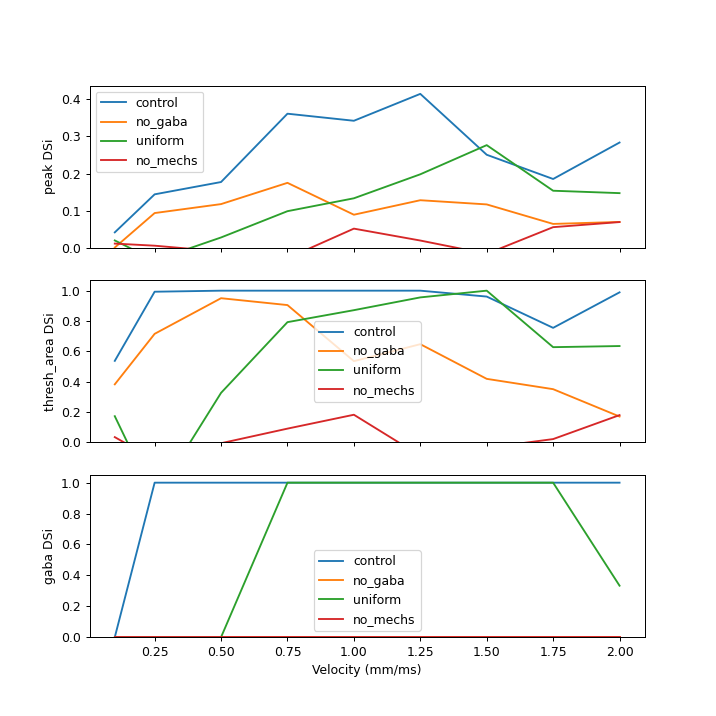

In [10]:
dsi_fig, dsi_ax = plt.subplots(len(dsis["control"]), sharex=True, figsize=(8, 8))
for (cond, ds) in dsis.items():
    for a, d in zip(dsi_ax, ds.values()):    
        a.plot(velocities, np.mean(d, axis=0), label=cond)

for a, metric in zip(dsi_ax, dsis["control"].keys()):
    a.set_ylabel("%s DSi" % metric)
    a.set_ylim(0)
    a.legend()

dsi_ax[-1].set_xlabel("Velocity (mm/ms)")
dsi_fig.show()

### Terminal membrane voltage and (proximal) GABA conductance
Trial averages of membrane voltage (recorded at the distal tip) for each membrane, along with the GABA conductance they recieved proximal to their soma from the opposing SAC. Legend indicates the velocity (in mm/ms) corresponding to each mean recording presented.

<IPython.core.display.Javascript object>


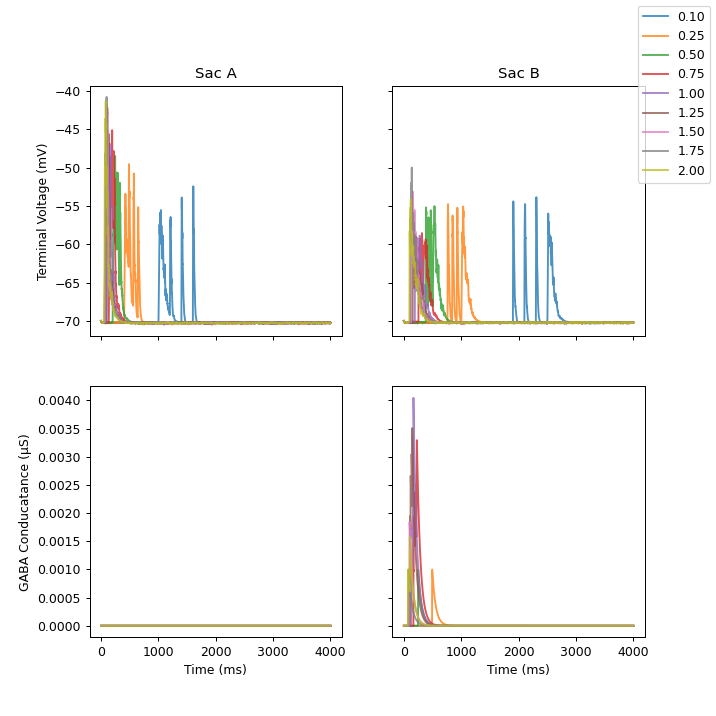

In [8]:
recs_fig, recs_ax = plt.subplots(2, 2, sharex="col", sharey="row",figsize=(8, 8))

alpha = .8
for vel, v_a, v_b, g_a, g_b in zip(
    velocities,
    np.mean(exps["control"]["term"]["a"]["v"], axis=0), 
    np.mean(exps["control"]["term"]["b"]["v"], axis=0),
    np.mean(exps["control"]["gaba"]["a"]["g"], axis=0),
    np.mean(exps["control"]["gaba"]["b"]["g"], axis=0)
):
    recs_ax[0][0].plot(rec_xaxis, v_a, alpha=alpha)
    recs_ax[0][1].plot(rec_xaxis, v_b, alpha=alpha)
    recs_ax[1][0].plot(rec_xaxis, g_a, alpha=alpha)
    recs_ax[1][1].plot(rec_xaxis, g_b, label="%.2f" % vel, alpha=alpha)

recs_ax[0][0].set_title("Sac A")
recs_ax[0][1].set_title("Sac B")
recs_ax[0][0].set_ylabel("Terminal Voltage (mV)")
recs_ax[1][0].set_ylabel("GABA Conducatance (μS)")
recs_ax[1][0].set_xlabel("Time (ms)")
recs_ax[1][1].set_xlabel("Time (ms)")
recs_fig.legend()
recs_fig.show()